In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE

In [187]:
data = pd.read_csv('nhis_2022.csv')

# Select important columns
selected_columns = ['CHEARTDIEV', 'AGE', 'SEX', 'BMICALC', 'HRSLEEP', 'HOURSWRK']
df = data[selected_columns]

In [188]:
def clean_codes(x):
    return np.nan if x in [7,8,9,96,97,98,99,996,997,998,999] else x

for col in ['AGE', 'SEX', 'BMICALC', 'HRSLEEP', 'HOURSWRK']:
    df.loc[:, col] = df[col].apply(clean_codes)

df.loc[:, 'CHEARTDIEV'] = df['CHEARTDIEV'].map({2: 1, 1: 0})
df = df.dropna()

/var/folders/s6/grcp2pz16xx4l9v8xh1xx__c0000gn/T/ipykernel_40156/3114323117.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[61. 43. 12. ... 12. 61.  6.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, col] = df[col].apply(clean_codes)
/var/folders/s6/grcp2pz16xx4l9v8xh1xx__c0000gn/T/ipykernel_40156/3114323117.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1. 1. 2. ... 2. 2. 1.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, col] = df[col].apply(clean_codes)
/var/folders/s6/grcp2pz16xx4l9v8xh1xx__c0000gn/T/ipykernel_40156/3114323117.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[nan  6.  0. ...  0.  5.  0.]' has dtype incompatible with int64, please expli

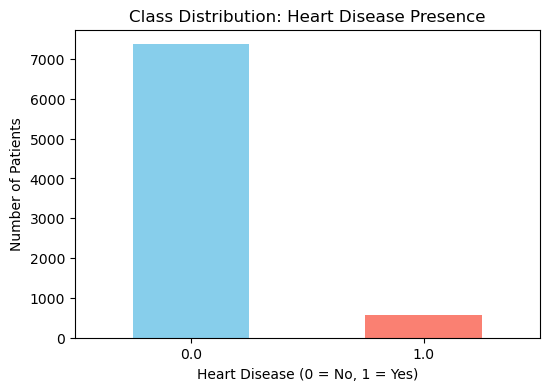

In [189]:
# class distribution
plt.figure(figsize=(6,4))
df['CHEARTDIEV'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution: Heart Disease Presence')
plt.xlabel('Heart Disease (0 = No, 1 = Yes)')
plt.ylabel('Number of Patients')
plt.xticks(rotation=0)
plt.show()

In [190]:
# Split and scale
X = df.drop('CHEARTDIEV', axis=1)
y = df['CHEARTDIEV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [191]:
# SMOTE
sm = SMOTE(random_state=50)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train_scaled, y_train)

print("Class distribution after SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

Class distribution after SMOTE:
CHEARTDIEV
0.0    5146
1.0    5146
Name: count, dtype: int64


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [192]:
# Training Linear SVM
linear_svc = SVC(kernel='linear', C=1)
linear_svc.fit(X_train_resampled, y_train_resampled)

SVC(C=1, kernel='linear')

In [193]:
# Predict and Evaluate
y_pred = linear_svc.predict(X_test_scaled)

print("Linear SVM")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Linear SVM
Accuracy: 0.6845863082738345
Confusion Matrix:
 [[1495  725]
 [  26  135]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.67      0.80      2220
         1.0       0.16      0.84      0.26       161

    accuracy                           0.68      2381
   macro avg       0.57      0.76      0.53      2381
weighted avg       0.93      0.68      0.76      2381




Feature Importance (Linear SVM):
AGE         0.909650
HOURSWRK    0.469157
SEX         0.231063
BMICALC     0.156126
HRSLEEP     0.027880
dtype: float64


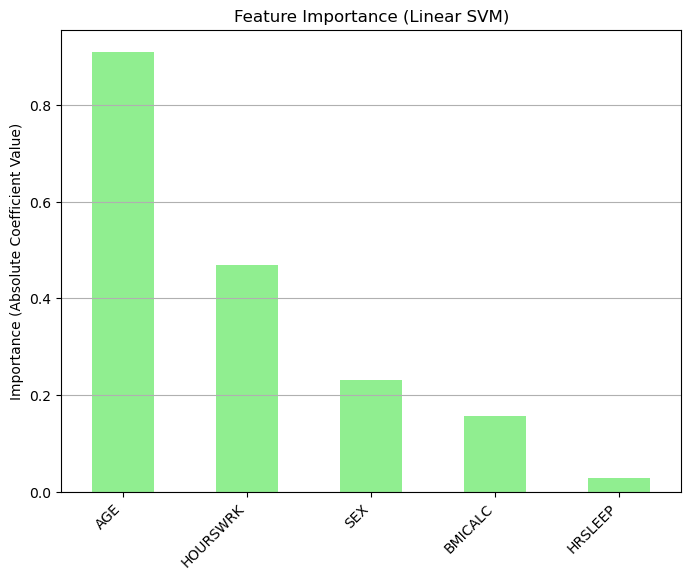

In [194]:
# Feature Importance
linear_importance = pd.Series(np.abs(linear_svc.coef_[0]), index=X.columns)
print("\nFeature Importance (Linear SVM):")
print(linear_importance.sort_values(ascending=False))

plt.figure(figsize=(8,6))
linear_importance.sort_values(ascending=False).plot(kind='bar', color='lightgreen')
plt.title('Feature Importance (Linear SVM)')
plt.ylabel('Importance (Absolute Coefficient Value)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


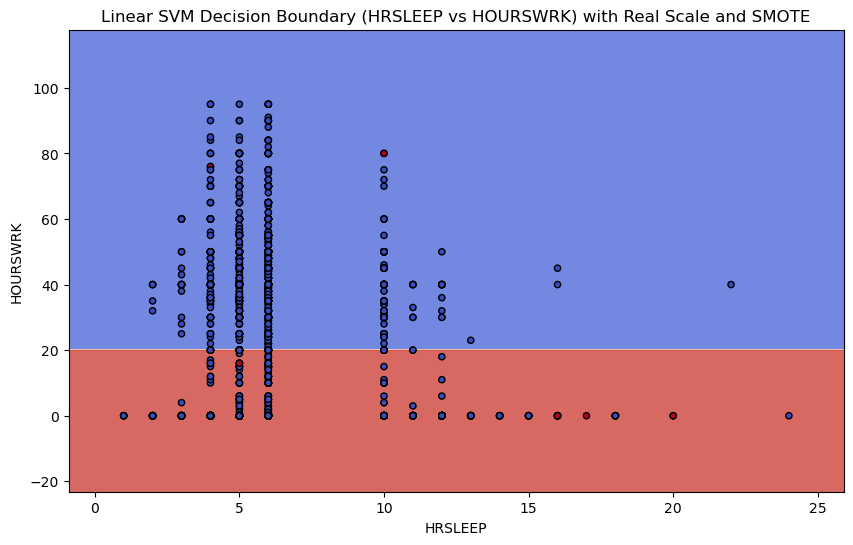

In [195]:
# decision boundaries 

def plot_decision_boundary(var1, var2):
    X_vis = df[[var1, var2]]
    y_vis = df['CHEARTDIEV']
    
    X_train_vis, _, y_train_vis, _ = train_test_split(X_vis, y_vis, test_size=0.3, random_state=50)
    scaler_vis = StandardScaler()
    X_train_vis_scaled = scaler_vis.fit_transform(X_train_vis)

    sm_vis = SMOTE(random_state=50)
    X_train_vis_resampled, y_train_vis_resampled = sm_vis.fit_resample(X_train_vis_scaled, y_train_vis)

    svc_vis = SVC(kernel='linear', C=1)
    svc_vis.fit(X_train_vis_resampled, y_train_vis_resampled)

    # Creating a meshgrid
    h = .02
    x_min, x_max = X_train_vis_scaled[:, 0].min() - 1, X_train_vis_scaled[:, 0].max() + 1
    y_min, y_max = X_train_vis_scaled[:, 1].min() - 1, X_train_vis_scaled[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Predict
    Z = svc_vis.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Inverse transform the meshgrid
    mesh = np.c_[xx.ravel(), yy.ravel()]
    mesh_real = scaler_vis.inverse_transform(mesh)
    xx_real = mesh_real[:, 0].reshape(xx.shape)
    yy_real = mesh_real[:, 1].reshape(yy.shape)

    plt.figure(figsize=(10,6))
    plt.contourf(xx_real, yy_real, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    real_points = scaler_vis.inverse_transform(X_train_vis_scaled)
    plt.scatter(real_points[:, 0], real_points[:, 1], c=y_train_vis, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.title(f'Linear SVM Decision Boundary ({var1} vs {var2}) with Real Scale and SMOTE')
    plt.show()

plot_decision_boundary('HRSLEEP', 'HOURSWRK')

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


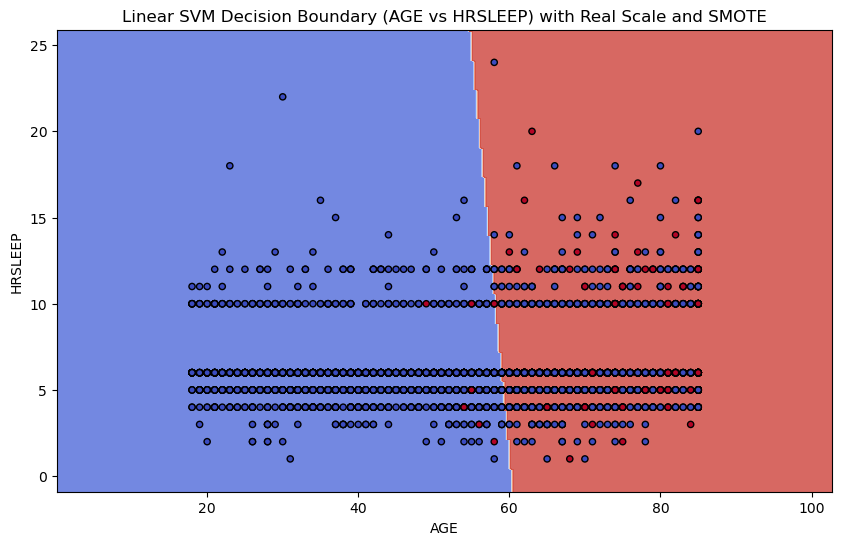

In [196]:
plot_decision_boundary('AGE', 'HRSLEEP')

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


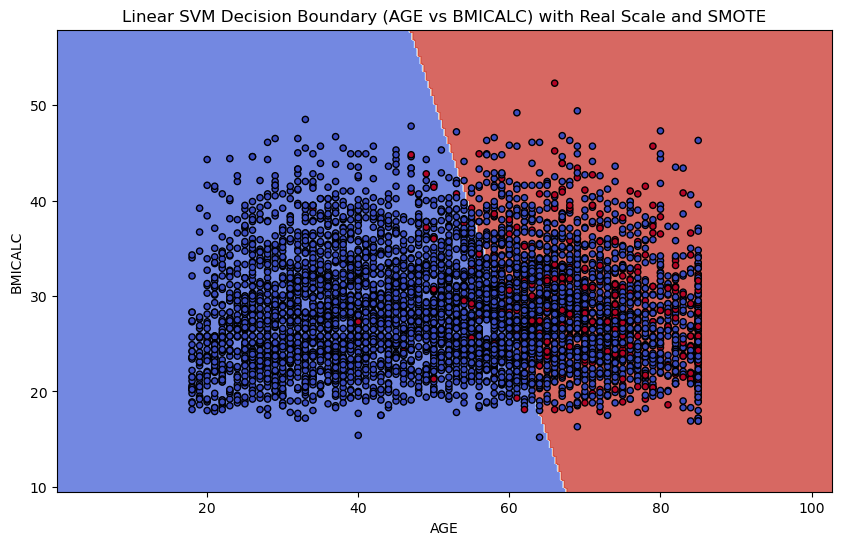

In [197]:
plot_decision_boundary('AGE', 'BMICALC')

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


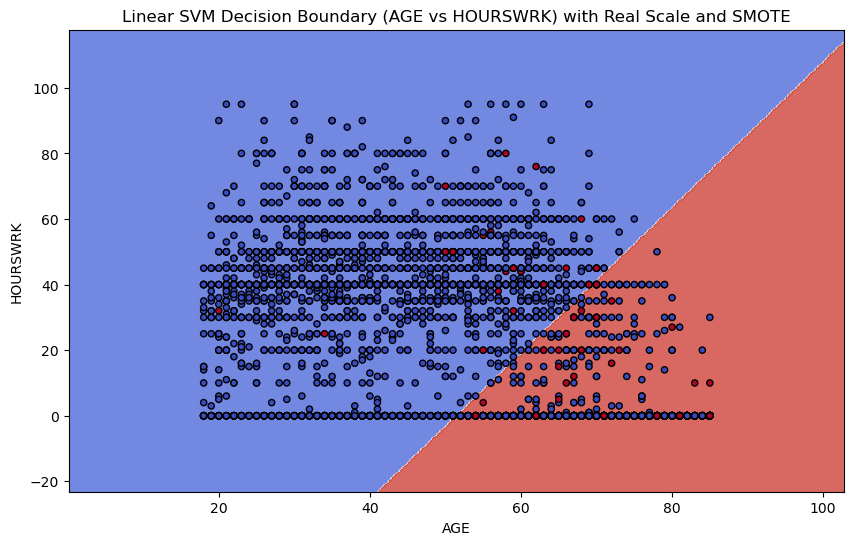

In [198]:
plot_decision_boundary('AGE', 'HOURSWRK')